In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import wandb
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from easydict import EasyDict

from model.regression import *

device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_split_indices(params):
    n_features = math.ceil(params.sr * params.window_length / params.hop_length)
    n_features_in_sec = params.sr / params.hop_length
    n_features_in_frame = params.frame_length * n_features_in_sec
    n_half_features_in_frame = n_features_in_frame / 2
    centers = torch.linspace(n_half_features_in_frame, n_features - n_half_features_in_frame, steps=params.n_frames)
    split_indices = []
    for c in centers:
        from_idx = int(c - n_half_features_in_frame)
        to_idx = int(c + n_half_features_in_frame)
        split_indices.append([from_idx, to_idx])
    return split_indices

In [4]:
audio_file = 'data/audio/20190819-Kutna Hora-L4-out-MVI_0040.wav'
labels_file = 'data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt'

signal, sr = torchaudio.load(audio_file)
signal = signal.mean(0)

events = np.loadtxt(labels_file)

### Load runs

In [5]:
api = wandb.Api()
runs = api.runs('yermandy/vehicle-audio-nn', per_page=1000, order='config.uuid')

configs = {}
val_loss_best = {}
for run in runs: 
    print(run.name)
    configs[run.name] = run.config
    val_loss_best[run.name] = run.summary['val loss best']

1627501085
1627502063
1627503143
1627504333
1627505376
1627507868
1627508963
1627506556
1627510233
1627512847
1627511666
1627514259
1627517017
1627518276
1627515885
1627519660
1627522222
1627520861
1627523741
1627526453
1627525020
1627529594
1627528069
1627531419
1627533523
1627534721
1627536022
1627537427
1627538688
1627540084
1627541629
1627542941
1627546097
1627547659
1627544427


In [6]:
uuid = 1627538688

params = EasyDict(configs[str(uuid)])
split_indices = get_split_indices(params)

params

{'sr': 44100,
 'uuid': 1627538688,
 'n_fft': 1024,
 'n_mels': 64,
 'n_mfcc': 8,
 'n_frames': 4,
 'hop_length': 128,
 'frame_length': 2,
 'window_length': 7}

### Define parameters

In [7]:
def define_params():
    # define parameters
    params = EasyDict()
    # length of one window in seconds
    params.window_length = 5
    # length of one frame in seconds
    params.frame_length = 1.5
    # number of frames in one window
    params.n_frames = 3
    # length of one feature in samples
    params.n_fft = 1024
    # number of mel features
    params.n_mels = 64
    # number of mfcc features
    params.n_mfcc = 8
    # sampling rate
    params.sr = 44100
    # hop length between samples for feature extractor
    params.hop_length = 128

# params = define_params()
# split_indices = get_split_indices(params)
# params

### Load model and dataset

In [8]:
model = ResNet18().to(device)
weights = torch.load(f'weights/regression/model_{uuid}.pth', device)
model.load_state_dict(weights)

<All keys matched successfully>

In [9]:
val_dataset = VehicleDataset(audio_file, labels_file, start_time=25 * 60, seed=0, params=params)
val_loader = DataLoader(val_dataset, batch_size=32)

x, y = next(iter(val_loader))
x.shape

all: 72 | positive: 50


torch.Size([32, 1, 72, 2412])

### Validate loss

In [10]:
val_loss = 0

model.eval()
with torch.no_grad():
    for tensor, target in val_loader:
        tensor = tensor.to(device)
        target = target.to(device)
        
        n_samples = tensor.shape[0]

        Y = torch.zeros(n_samples).to(device)

        for from_idx, to_idx in split_indices:
            x = tensor[..., from_idx:to_idx]
            Y += model(x).squeeze()
            
        loss_value = (Y - target).abs().sum()

        val_loss += loss_value.detach().item()

f'estimated: {val_loss:.4f}       wandb: {val_loss_best[str(uuid)]:.4f}'

/home/yermaand/miniconda3/envs/dev/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


'estimated: 24.5774       wandb: 24.5788'

### Test

In [11]:
start_time = 25 * 60
interval = 9 * 60

end_time = start_time + interval
signal_interval = signal[start_time * sr: end_time * sr]

results = []

n_samples_in_frame = int(params.frame_length * params.sr)

K = len(signal_interval) // n_samples_in_frame
E = events[(events >= start_time) & (events < end_time)]
T = np.linspace(start_time, end_time, K)

model.eval()
with torch.no_grad():
    for k in tqdm(range(K)):
        x = signal_interval[k * n_samples_in_frame : (k + 1) * n_samples_in_frame]
        x = val_dataset.transform(x).unsqueeze(0)
        x = x.to(device)
        y = model(x).abs().item()
        results.append(y)

  0%|          | 0/270 [00:00<?, ?it/s]

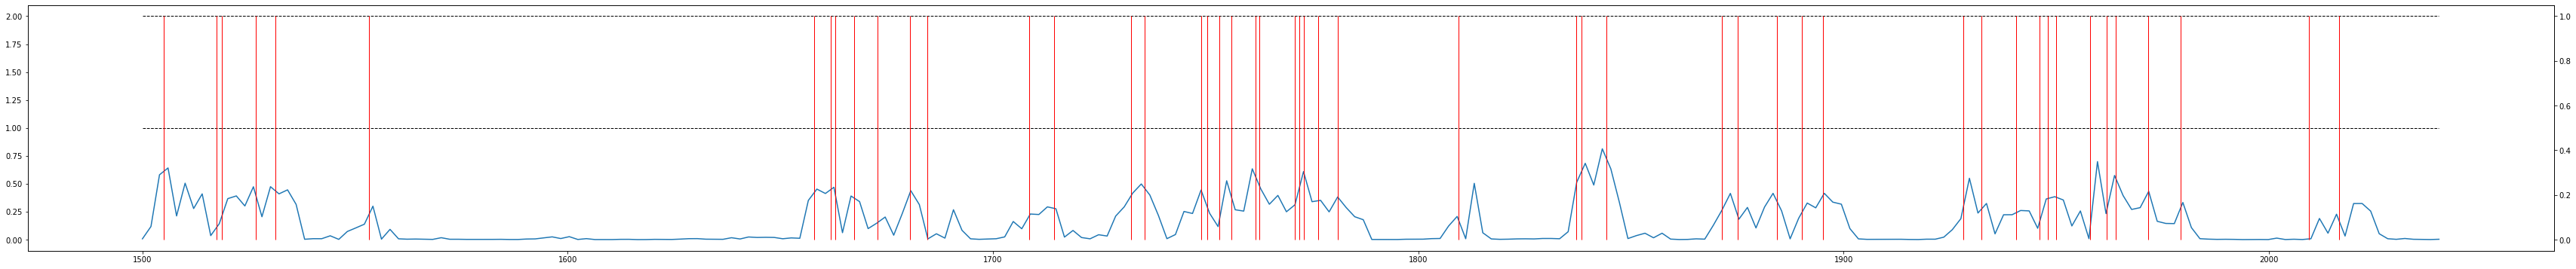

In [13]:
# results = np.convolve(results, np.ones(3), 'valid')

fig, ax1 = plt.subplots(figsize=(60, 6))
ax2 = ax1.twinx()
ax1.plot(T, results)
ax1.hlines(1.0, T[0], T[-1], color='k', linestyle='--', linewidth=1.0)
ax1.hlines(2.0, T[0], T[-1], color='k', linestyle='--', linewidth=1.0)

for event in E:
    ax2.vlines(event, 0, 1, color='r', linewidth=1.0)

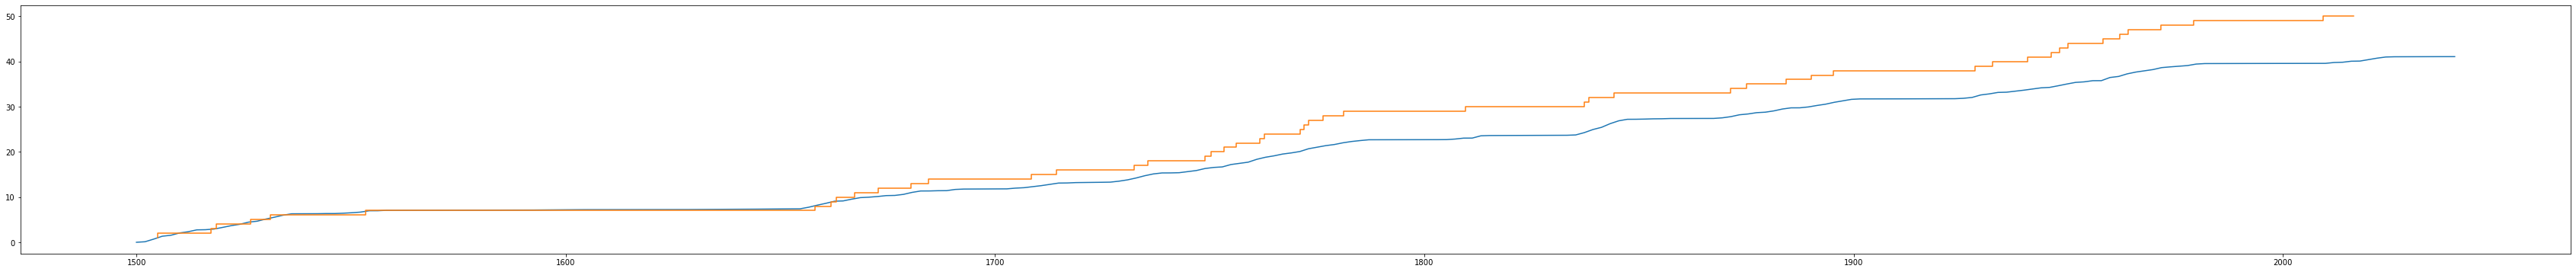

In [14]:
cumsum = np.cumsum(results)

fig, ax = plt.subplots(figsize=(60, 6))
ax.plot(T, cumsum)
ax.step(E, np.arange(1, len(E) + 1));